# Evaluation of Politeness Classifier
Name: Arisa Shiraishi

This notebook try to reproduce the result presented in the paper, *'A computational approach to politeness with application to social factors'*, using the tool provided by Convokit.


### General Instruction
To download Spacy english module, run
- python -m spacy download en 

In [1]:
import pandas as pd
import numpy as np
import nltk
from tqdm import tqdm
from collections import defaultdict
from pandas import DataFrame
from typing import List, Dict, Set
try:
    import convokit
except ModuleNotFoundError:
    !pip install convokit

### 1. Get Data from Stanford Politeness Corpus through convokit

In [2]:
from convokit import Corpus, Speaker, Utterance, download
wiki_corpus = Corpus(download("wikipedia-politeness-corpus"))
se_corpus = Corpus(download("stack-exchange-politeness-corpus"))

Dataset already exists at /Users/arisashiraishi/.convokit/downloads/wikipedia-politeness-corpus
Dataset already exists at /Users/arisashiraishi/.convokit/downloads/stack-exchange-politeness-corpus


#### An example of random data from politeness corpus

In [32]:
ran_wiki_utt = wiki_corpus.random_utterance()
print("RAW TEXT: " + ran_wiki_utt.text + "\n")
print("Normalized Score: " + str(ran_wiki_utt.meta.get('Normalized Score')) + "\n")
print("Binary: " + str(ran_wiki_utt.meta.get('Binary')) + "\n")
print("Annotation: " + str(ran_wiki_utt.meta.get('Annotations')) + "\n")

RAW TEXT: If you are beccoming a target again do you want semi prot for a while? How much activity is it getting?

Normalized Score: -0.2258013793481852

Binary: 0

Annotation: {'AZN83WTGUR1JZ': 17, 'A26YKYQIA3GX8B': 13, 'A28TXBSZPWMEU9': 11, 'A3GOI327COFGY5': 13, 'A2AMGE57IJVSHF': 9}



#### Small missmatch in number of annotated texts exhibit in Table 1 of the paper. 
Papper reported 4353 wiki and 6604 se annoted texts but...

In [4]:
wiki_corpus_len = len(wiki_corpus.get_utterance_ids())
se_corpus_len = len(se_corpus.get_utterance_ids())
print(str(wiki_corpus_len) + " sets of texts found in wikipedia-politeness-corpus")
print(str(se_corpus_len) + " sets of texts found in stack-exchange-politeness-corpus")

4353 sets of texts found in wikipedia-politeness-corpus
6603 sets of texts found in stack-exchange-politeness-corpus


### 2. Extract features using Convokit

#### 2-a Extract BoW feature

In [5]:
from convokit import BoWTransformer
from sklearn.feature_extraction.text import CountVectorizer

# Add bow feature to corpus
# Unigrams appearing less than 10 times are excluded.
# Return vocaburary of given corpus list of words
def generate_bow_features(doc, min_unigram_count=10):
    vc = CountVectorizer(min_df=min_unigram_count)
    bow = BoWTransformer(obj_type="utterance", vectorizer=vc)
    bow.fit_transform(doc)
    return bow.get_vocabulary()

#### 2-b Extract politeness strategies feature

__Input__: Requests must be pre-processed with sentences and dependency parses. We used nltk's PunktSentenceTokenizer for sentence tokenization and Stanford CoreNLP version 1.3.3 for dependency parsing.

In [6]:
# python -m spacy download en
from convokit import TextParser 
from convokit import PolitenessStrategies

In [7]:
# Add politeness features to meta
def generate_politeness_features(corpus):
    # preprocess
    parser = TextParser(verbosity=3000)
    corpus = parser.transform(corpus) 
    
    ps = PolitenessStrategies()
    ps.transform(corpus, markers=True)

- print out politeness markers found in random datapoint from the corpus

In [8]:
generate_politeness_features(wiki_corpus)
# se_corpus = ps.transform(se_corpus, markers=True)

3000/4353 utterances processed
4353/4353 utterances processed


- Summary of overall use of politeness strategies in given corpus

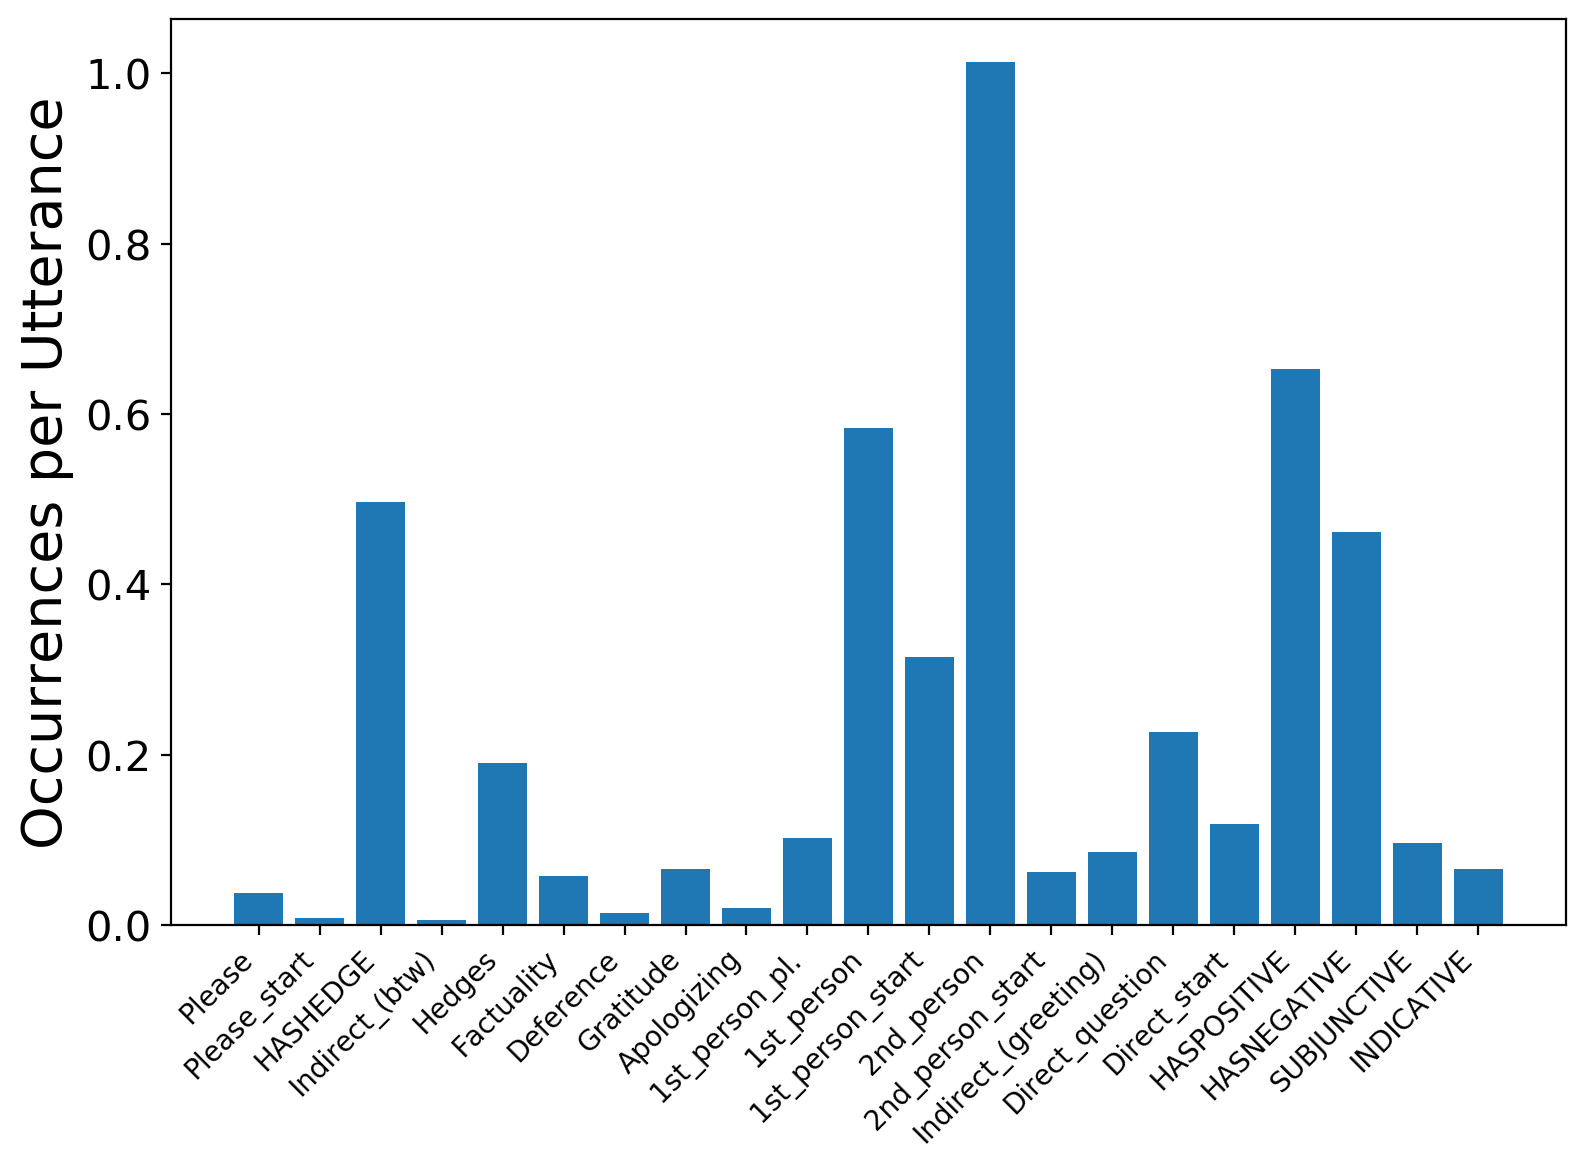

,Averages
Please,0.037445
Please_start,0.007811
HASHEDGE,0.497128
Indirect_(btw),0.005513
Hedges,0.190673
Factuality,0.057202
Deference,0.014243
Gratitude,0.066391
Apologizing,0.019986
1st_person_pl.,0.102458


In [9]:
ps = PolitenessStrategies()
ps.transform(wiki_corpus, markers=True)
ps.summarize(wiki_corpus, plot=True)
# ps.summarize(se_corpus, plot=True)

### 3. Train Politeness Classifier 

In [10]:
import random
from sklearn import svm
from scipy.sparse import csr_matrix
from sklearn.metrics import classification_report
from convokit import Classifier
from convokit.classifier.vectorClassifier import VectorClassifier

#### 3-a. Preprocess the corpus: 
- only consider binary politeness (polite/impolite)

In [11]:
binary_wiki_corpus = Corpus(utterances=[utt for utt in wiki_corpus.iter_utterances() if utt.meta["Binary"] != 0])
binary_se_corpus = Corpus(utterances=[utt for utt in se_corpus.iter_utterances() if utt.meta["Binary"] != 0])

### 3-b. SVM with BoW feature

In [12]:
def train_bow_clf(corpus):
    if "bow_vector" not in corpus.vectors:
        generate_bow_features(corpus)
    X = corpus.get_vectors('bow_vector')
    y = np.array([ utt.meta.get('Binary') for utt in corpus.iter_utterances()])
    clf = svm.SVC(C=0.02, kernel='linear', probability=True)
    clf.fit(X,y)
    return clf

In [13]:
wiki_bow_clf = train_bow_clf(binary_wiki_corpus)
se_bow_clf = train_bow_clf(binary_se_corpus)

### 3-c. SVM with BoW + Politeness strategy (ps) feature

In [14]:
# Utility function to combine bow vector and ps vector 
def ps_vectorizer(corpus):
    bow_vec = corpus.get_vectors('bow_vector').toarray()
    #Reshape the bow matrix to fit politeness strategy features
    corpus_size = len(corpus.get_utterance_ids())
    ling_featutres_size = len(bow_vec[0]) + len(corpus.random_utterance().meta.get("politeness_strategies"))
    ling_vec = np.zeros((corpus_size,ling_featutres_size))
    i = 0
    for utt in  corpus.iter_utterances():
        d = utt.meta.get("politeness_strategies")
        ling_vec[i] = np.append(bow_vec[i], [d[k] for k in d])
        i += 1
    return ling_vec

In [15]:
def train_ling_clf(corpus, ling=False):
    if "bow_vector" not in corpus.vectors:
        generate_bow_features(corpus)
    if "politeness_strategies" not in corpus.random_utterance().meta:
        generate_politeness_features(corpus)
    X = ps_vectorizer(corpus)          
    y = np.array([ utt.meta.get('Binary') for utt in corpus.iter_utterances()])
    clf = svm.SVC(C=0.02, kernel='linear', probability=True)
    clf.fit(X,y)
    return clf

In [16]:
wiki_ling_clf = train_ling_clf(binary_wiki_corpus)
se_ling_clf = train_ling_clf(binary_se_corpus)

3000/3302 utterances processed
3302/3302 utterances processed


### 4. Evaluate the model 

#### 4-a.  In domain, Cross validation (cv=5 by default)

In [17]:
from sklearn.model_selection import cross_val_score

In [18]:
def eval(corpus, ling=False, cv=5):
    if "bow_vector" not in corpus.vectors:
        generate_bow_features(corpus)
    if (ling):
        if "politeness_strategies" not in corpus.random_utterance().meta:
            parser = TextParser(verbosity=3000)
            corpus = parser.transform(corpus) 
            ps = PolitenessStrategies()
            ps.transform(corpus, markers=True)
        X = ps_vectorizer(corpus)          
    else:
        X = corpus.get_vectors('bow_vector')
    y = np.array([ utt.meta.get('Binary') for utt in corpus.iter_utterances()])
    clf = svm.SVC(C=0.02, kernel='linear', probability=True)
    scores = cross_val_score(clf, X, y, cv=cv)
    print("Accuracy: %0.5f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [19]:
binary_se_corpus.get_vectors('bow_vector')

<3302x719 sparse matrix of type '<class 'numpy.int64'>'
	with 47494 stored elements in Compressed Sparse Row format>

In [20]:
eval(binary_wiki_corpus) 

Accuracy: 0.78467 (+/- 0.04)


In [21]:
eval(binary_wiki_corpus, ling=True)

Accuracy: 0.81177 (+/- 0.05)


In [22]:
eval(binary_se_corpus) 

Accuracy: 0.61503 (+/- 0.17)


In [23]:
eval(binary_se_corpus, ling=True) 

Accuracy: 0.62684 (+/- 0.20)


#### 4-b. In domain, standard LeaveOneOut evaluation (Takes way too long) 

In [24]:
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score

In [25]:
def loo_eval(corpus):
    X = corpus.get_vectors('bow_vector').toarray()
    y = np.array([ utt.meta.get('Binary') for utt in corpus.iter_utterances()])
    cv = LeaveOneOut()
    y_true, y_pred = list(), list()
    for train_ix, test_ix in cv.split(X):
        # split data
        X_train, X_test = X[train_ix, :], X[test_ix, :]
        y_train, y_test = y[train_ix], y[test_ix]
        # fit model
        model = svm.SVC(C=0.02, kernel='linear', probability=True)
        model.fit(X_train, y_train)
        # evaluate model
        yhat = model.predict(X_test)
        # store
        y_true.append(y_test[0])
        y_pred.append(yhat[0])
    # calculate accuracy
    acc = accuracy_score(y_true, y_pred)
    print('Accuracy: %.3f' % acc)

### 5.  Predicte politeness of unknown text

In [26]:
from nltk.tokenize import word_tokenize

In [27]:
wiki_vocab = generate_bow_features(binary_wiki_corpus)
se_vocab = generate_bow_features(binary_se_corpus)

In [28]:
# Return -1 if impolite 1 if polite
def predict(document, clf, corpus, vocab, ling=False):
#    vocab = generate_bow_features(corpus)
    tokens = word_tokenize(document)
    bow_vec = np.zeros(len(vocab))
    for tok in tokens:
        if tok in vocab:
            idx = vocab.index(tok)
            bow_vec[idx] += 1
    if ling:
        utt = Utterance(text=document)
        ps = PolitenessStrategies().transform_utterance(utt).meta.get('politeness_strategies')
        ps_vec = [ps[p] for p in ps]
        ling_vec = np.append(bow_vec, ps_vec)
        # predict_proba
        return (clf.predict([ling_vec])[0])
    else:
        return (clf.predict([bow_vec])[0])          

In [53]:
def print_predict(document):
    pred2label = {1: "Polite", -1: "Impolite"}
    wiki_bow_clf_res = predict(document, wiki_bow_clf, binary_wiki_corpus, wiki_vocab)
    wiki_ling_clf_res = predict(document, wiki_ling_clf, binary_wiki_corpus, wiki_vocab, ling=True)
    se_bow_clf_res = predict(document, se_bow_clf, binary_se_corpus, se_vocab)
    se_ling_clf_res = predict(document, se_ling_clf, binary_se_corpus, se_vocab, ling=True)
    print("test text:\n{}".format(document))
    print("------------------------")
    print("BoW model + Wiki corpus: {}".format(pred2label[wiki_bow_clf_res]))
    print("BoW model + Stack Exchange corpus: {}".format(pred2label[se_bow_clf_res]))
    print("Ling model + Wiki corpus: {}".format(pred2label[wiki_ling_clf_res]))
    print("Ling model + Stack Exchange corpus: {}".format(pred2label[se_ling_clf_res])) 
    

In [71]:
text1 = "Have you found the answer for your question? If yes would you please share it?"

In [56]:
text2 = "This was supposed to have been moved to &lt;url&gt; per the cfd. why wasn't it moved?"

In [51]:
text3 = "Sorry :) I dont want to hack the system!! :) is there another way?"

In [52]:
print_predict(text3)

input text:
I would like a pizza
------------------------
result
BoW model: Polite
Ling model: Polite


## 6. Experiment!

According to a follow up study by Aubakirova and Bansal (2016), “Though non-characteristic in direct speech, punctuation appears to be an important special marker in online communities, which in some sense captures verbal emotion in text.” (Aubakirova and Bansal 2016)

In [31]:
import re
punctuation = re.compile('(([!\?.])\\2+)')

In [32]:
# return politeness starategy vector with additional politeness strategy suggested by Aubakirova and Bansal.
def ps_vectorizer_plus(corpus):
    bow_vec = corpus.get_vectors('bow_vector').toarray()
    corpus_size = len(corpus.get_utterance_ids())
    ling_featutres_size = len(bow_vec[0]) + len(corpus.random_utterance().meta.get("politeness_strategies"))
    ling_vec = np.zeros((corpus_size, ling_featutres_size + 1))
    i = 0
    for utt in  corpus.iter_utterances():
        punc = 0
        match = punctuation.search(utt.text)
        if match:
            punc = 1
        d = utt.meta.get("politeness_strategies")
        ps_plus_vec = np.append([d[k] for k in d], punc)
        ling_vec[i] = np.append(bow_vec[i], ps_plus_vec )
        i += 1
    return ling_vec

In [33]:
def eval_ling_plus(corpus, cv=5):
    if "bow_vector" not in corpus.vectors:
        generate_bow_features(corpus)
    if "politeness_strategies" not in corpus.random_utterance().meta:
        parser = TextParser(verbosity=3000)
        corpus = parser.transform(corpus) 
        ps = PolitenessStrategies()
        ps.transform(corpus, markers=True)
    
    X = ps_vectorizer_plus(corpus)          
    y = np.array([ utt.meta.get('Binary') for utt in corpus.iter_utterances()])
    clf = svm.SVC(C=0.02, kernel='linear', probability=True)
    scores = cross_val_score(clf, X, y, cv=cv)
    print("Accuracy: %0.5f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [34]:
eval_ling_plus(binary_wiki_corpus)
# baseline ling Accuracy: 0.81177

Accuracy: 0.81635 (+/- 0.05)


In [35]:
eval_ling_plus(binary_se_corpus)
# baseline ling Accuracy: 0.62684 (+/- 0.20)

Accuracy: 0.62382 (+/- 0.19)
